In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
mnistFile = open("mnist.csv")
df = pd.read_csv(mnistFile)
numbers = sorted(list(set(df["label"])))

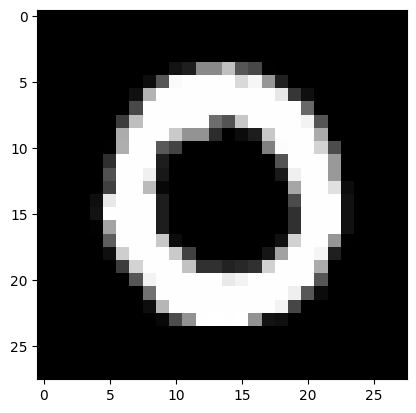

In [3]:
plt.imshow(df.iloc[1, 1:].values.reshape(28, 28), cmap='gray')
plt.show()

In [4]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Split the dataset into base (0-5) and extra (6-9)
base_df = df[df['label'].isin([0, 1, 2, 3, 4, 5])]
extra_df = df[df['label'].isin([6, 7, 8, 9])]

# Split the features and labels
X_base = base_df.drop(columns=['label'])
y_base = base_df['label']
X_extra = extra_df.drop(columns=['label'])
y_extra = extra_df['label']
X = df.drop(columns=['label'])
y = df['label']

# Perform train-test split for base, extra, and whole dataset
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)
X_extra_train, X_extra_test, y_extra_train, y_extra_test = train_test_split(X_extra, y_extra, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the splits
print("Base train shape:", X_base_train.shape, y_base_train.shape)
print("Base test shape:", X_base_test.shape, y_base_test.shape)
print("Extra train shape:", X_extra_train.shape, y_extra_train.shape)
print("Extra test shape:", X_extra_test.shape, y_extra_test.shape)
print("Whole train shape:", X_train.shape, y_train.shape)
print("Whole test shape:", X_test.shape, y_test.shape)

Base train shape: (20168, 784) (20168,)
Base test shape: (5043, 784) (5043,)
Extra train shape: (13431, 784) (13431,)
Extra test shape: (3358, 784) (3358,)
Whole train shape: (33600, 784) (33600,)
Whole test shape: (8400, 784) (8400,)


In [6]:
from torch.utils.data import Dataset, DataLoader

class MNISTDataset(Dataset):
  def __init__(self, data, labels):
    self.data = torch.tensor(data.values, dtype=torch.float32)
    self.labels = torch.tensor(labels.values, dtype=torch.long)
  
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

# Create datasets
train_dataset = MNISTDataset(X_train, y_train)
test_dataset = MNISTDataset(X_test, y_test)
base_train_dataset = MNISTDataset(X_base_train, y_base_train)
base_test_dataset = MNISTDataset(X_base_test, y_base_test)
extra_train_dataset = MNISTDataset(X_extra_train, y_extra_train)
extra_test_dataset = MNISTDataset(X_extra_test, y_extra_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
base_train_loader = DataLoader(base_train_dataset, batch_size=64, shuffle=True)
base_test_loader = DataLoader(base_test_dataset, batch_size=64, shuffle=False)
extra_train_loader = DataLoader(extra_train_dataset, batch_size=64, shuffle=True)
extra_test_loader = DataLoader(extra_test_dataset, batch_size=64, shuffle=False)

# Print the sizes of the datasets
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))
print("Base train dataset size:", len(base_train_dataset))
print("Base test dataset size:", len(base_test_dataset))
print("Extra train dataset size:", len(extra_train_dataset))
print("Extra test dataset size:", len(extra_test_dataset))

Train dataset size: 33600
Test dataset size: 8400
Base train dataset size: 20168
Base test dataset size: 5043
Extra train dataset size: 13431
Extra test dataset size: 3358


In [7]:
F = nn.functional
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, 10)
    self.dropout = nn.Dropout(0.25)
    
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 64 * 7 * 7)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

# Instantiate the model, define the loss function and the optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Print the model architecture
print(model)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [8]:
def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
  model.train()
  for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
      inputs = inputs.view(inputs.size(0), 1, 28, 28)  # Reshape inputs to (batch_size, 1, 28, 28)
      
      # Zero the parameter gradients
      optimizer.zero_grad()
      
      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      
      # Backward pass and optimize
      loss.backward()
      optimizer.step()
      
      # Print statistics
      running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [9]:
train_model(model,criterion, optimizer,base_train_loader,2)

Epoch [1/2], Loss: 0.3871
Epoch [2/2], Loss: 0.0376


In [12]:
def inference(model, loader):
  model.eval()
  all_preds = []
  all_labels = []
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.view(inputs.size(0), 1, 28, 28)  # Reshape inputs to (batch_size, 1, 28, 28)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
 
  accuracy = accuracy_score(all_labels, all_preds)
  print(f"Accuracy on base test set: {accuracy:.4f}")

  conf_matrix = confusion_matrix(all_labels, all_preds)
  print("Confusion Matrix:")
  print(conf_matrix)

In [11]:
torch.save(model,"model.pt")

In [37]:
def compute_fisher_information(model, data_loader, criterion):
  model.eval()
  fisher_information = {}
  for name, param in model.named_parameters():
    fisher_information[name] = torch.zeros_like(param)

  for inputs, labels in data_loader:
    inputs = inputs.view(inputs.size(0), 1, 28, 28)
    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()

    for name, param in model.named_parameters():
      fisher_information[name] += param.grad ** 2

  for name, _ in fisher_information.items():
    fisher_information[name] /= len(data_loader.dataset)

  return fisher_information

def ewc_loss(new_model, old_model, fisher_information, lambda_ewc):
  loss = 0
  for name, param in new_model.named_parameters():
    old_param = old_model.state_dict()[name]
    fisher = fisher_information[name]
    loss += (fisher * (param - old_param) ** 2).sum()
  return lambda_ewc * loss

def train_with_ewc(new_model, old_model, fisher_information, criterion, optimizer, train_loader, lambda_ewc, num_epochs=10):
  new_model.train()
  for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
      inputs = inputs.view(inputs.size(0), 1, 28, 28)
      optimizer.zero_grad()
      outputs = new_model(inputs)
      loss = criterion(outputs, labels)
      ewc_penalty = ewc_loss(new_model, old_model, fisher_information, lambda_ewc)
      total_loss = loss + ewc_penalty
      total_loss.backward()
      optimizer.step()
      running_loss += total_loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

def generate_pseudo_data(model, num_samples=1000):
  model.eval()
  pseudo_data = []
  pseudo_labels = []
  for _ in range(num_samples):
    noise = torch.randn(1, 1, 28, 28)
    with torch.no_grad():
      output = model(noise)
      _, label = torch.max(output, 1)
      pseudo_data.append(noise.squeeze().numpy())
      pseudo_labels.append(label.item())
  return np.array(pseudo_data), np.array(pseudo_labels)

In [43]:
ewcModel = torch.load("model.pt")

In [ ]:
num_samples = 1000
pseudo_data, pseudo_labels = generate_pseudo_data(model, num_samples)

pseudo_dataset = MNISTDataset(pd.DataFrame(pseudo_data.reshape(num_samples, -1)), pd.Series(pseudo_labels))
pseudo_loader = DataLoader(pseudo_dataset, batch_size=64, shuffle=True)

fisher_information = compute_fisher_information(model, pseudo_loader, criterion)

train_with_ewc(ewcModel, model, fisher_information, criterion, optimizer, extra_train_loader, lambda_ewc=0.4, num_epochs=5)

In [ ]:
inference(ewcModel,extra_test_loader)